# 4. Modélisation — Baselines (Dummy → LogReg → RandomForest)

## Objectifs du notebook

L’objectif de ce notebook est de poser des **baselines de modélisation solides et interprétables** avant toute phase d’optimisation ou d’explicabilité avancée.

Nous allons :
- Construire un pipeline scikit-learn **reproductible** (préprocessing + modèle).
- Comparer trois familles de modèles :
  - un modèle **étalon** (DummyClassifier),
  - un modèle **linéaire interprétable** (Logistic Regression),
  - un modèle **non-linéaire** (RandomForest).
- Évaluer les performances avec des **métriques adaptées au déséquilibre de classes**.
- Poser les bases d’un **choix de seuil métier** via la courbe précision–rappel.

À ce stade, l’objectif n’est **pas** d’optimiser au maximum la performance, mais de comprendre :
- la difficulté intrinsèque du problème,
- le niveau de performance atteignable sans tuning,
- le compromis performance / interprétabilité.


## Traçabilité des expériences avec MLflow

Afin d’assurer la **reproductibilité** et la **comparabilité** des expériences, nous utilisons MLflow comme outil de tracking.

MLflow permet de :
- enregistrer automatiquement les paramètres des modèles,
- stocker les métriques d’évaluation,
- conserver les modèles entraînés,
- comparer facilement plusieurs runs.

Dans ce notebook, MLflow est utilisé en mode **local**.


In [ ]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("technova_attrition_baselines")
mlflow.sklearn.autolog()

g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/17 12:32:16 INFO mlflow.tracking.fluent: Experiment with name 'technova_attrition_baselines' does not exist. Creating a new experiment.


In [ ]:
!mlflow ui --backend-store-uri mlruns --port 5000

## Données utilisées

Nous utilisons le dataset `employees_features.parquet`, produit à l’issue du notebook précédent (feature engineering et contrôles de cohérence).

Ce dataset :
- résulte de la jointure des trois sources RH (SIRH, évaluations, sondage),
- contient uniquement des features nettoyées et prêtes pour la modélisation,
- inclut la variable cible `a_quitte_l_entreprise`.

! La cible est **déséquilibrée** : environ **16 %** des employés ont quitté l’entreprise.
Cela impose une attention particulière au choix des métriques d’évaluation.


## Définition de la cible et séparation train / test

La variable cible est :
- `a_quitte_l_entreprise` (binaire : 1 = a quitté, 0 = est resté).

Nous séparons les données en :
- un jeu d’entraînement,
- un jeu de test.

La séparation est réalisée avec une **stratification sur la cible**, afin de conserver la même proportion de démissions dans les deux ensembles.

Un `random_state` est fixé pour garantir la reproductibilité.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from technova_attrition.config import PATHS, SETTINGS
from technova_attrition.evaluation import (
    evaluate_classifier,
    find_threshold_for_recall,
    plot_precision_recall,
)
from technova_attrition.modeling import make_dummy, make_logreg, make_random_forest
from technova_attrition.preprocessing import FeatureGroups

df = pd.read_parquet(PATHS.data_processed / "employees_features.parquet")

TARGET = "a_quitte_l_entreprise"
assert TARGET in df.columns

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SETTINGS.random_state,
    stratify=y,  # keep the same proportion of classes in train and test sets
)
y.value_counts(normalize=True).round(3)

a_quitte_l_entreprise
0    0.839
1    0.161
Name: proportion, dtype: float64

## Typologie des variables et stratégie de prétraitement

Les variables sont regroupées selon leur **nature statistique** et leur **sens métier**, afin d’appliquer un prétraitement adapté.

Nous distinguons :
- des variables numériques continues,
- des variables numériques à forte asymétrie (log-transform),
- des variables numériques discrètes,
- des variables catégorielles binaires,
- des variables catégorielles nominales,
- des variables catégorielles ordinales.

Cette étape est essentielle pour :
- éviter des transformations inadaptées,
- garantir la cohérence des coefficients du modèle linéaire,
- répondre aux bonnes pratiques attendues en analyse exploratoire et modélisation.


## Sécurisation des colonnes utilisées

Dans un projet réel, les datasets peuvent évoluer (colonnes absentes, renommées, supprimées).

Afin de rendre le pipeline plus robuste, nous appliquons une étape défensive :
- seules les colonnes réellement présentes dans le DataFrame sont conservées.

Cela permet d’éviter des erreurs de type `KeyError` et facilite la maintenance du code.


In [2]:
# === Numériques ===
num_cont = [
    "age",
    "augmentation_salaire_precedente",
    "distance_domicile_travail",
    "proba_chgt_experience_par_an",
    "proba_chgt_experience_par_an_adulte",
    "ratio_experience_vie_adulte",
]

num_log = [
    "revenu_mensuel",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "annes_sous_responsable_actuel",
    "annees_depuis_la_derniere_promotion",
]

num_disc = [
    "nombre_participation_pee",
    "nb_formations_suivies",
    "nombre_employee_sous_responsabilite",
    "nombre_experiences_precedentes",
    "nombre_experiences_precedents",
]

# === Binaires ===
bin_cols = ["genre", "heure_supplementaires", "changement_poste"]

# === Nominales ===
cat_nom = ["statut_marital", "departement", "poste", "domaine_etude"]

# === Ordinales ===
cat_ord = [
    "satisfaction_employee_environnement",
    "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso",
    "note_evaluation_precedente",
    "note_evaluation_actuelle",
    "niveau_hierarchique_poste",
    "niveau_education",
    "frequence_deplacement",
    "evolution_note",
]


# Nettoyage automatique : on ne garde que les colonnes présentes
def keep_existing(cols):
    return [c for c in cols if c in X.columns]


num_cont = keep_existing(num_cont)
num_log = keep_existing(num_log)
num_disc = keep_existing(num_disc)
bin_cols = keep_existing(bin_cols)
cat_nom = keep_existing(cat_nom)
cat_ord = keep_existing(cat_ord)

# Ordres ordinal : par défaut, on prend l’ordre trié (tu pourras le remplacer par un ordre métier explicite)
ord_categories = [sorted(df[c].dropna().unique().tolist()) for c in cat_ord]

groups = FeatureGroups(
    num_cont=num_cont,
    num_log=num_log,
    num_disc=num_disc,
    bin_cols=bin_cols,
    cat_nom=cat_nom,
    cat_ord=cat_ord,
    ord_categories=ord_categories,
)

groups

FeatureGroups(num_cont=['age', 'distance_domicile_travail', 'proba_chgt_experience_par_an', 'proba_chgt_experience_par_an_adulte', 'ratio_experience_vie_adulte'], num_log=['revenu_mensuel', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'annes_sous_responsable_actuel', 'annees_depuis_la_derniere_promotion'], num_disc=['nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'nombre_experiences_precedentes'], bin_cols=['genre', 'heure_supplementaires', 'changement_poste'], cat_nom=['statut_marital', 'departement', 'poste', 'domaine_etude'], cat_ord=['satisfaction_employee_environnement', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_precedente', 'note_evaluation_actuelle', 'niveau_hierarchique_poste', 'niveau_education', 'frequence_deplacement', 'evolution_note'], ord_categories=[[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2,

## Construction du pipeline de modélisation

Toutes les étapes de transformation et de modélisation sont encapsulées dans un **Pipeline scikit-learn**.

Avantages :
- évite toute fuite de données (data leakage),
- garantit que le préprocessing est appris uniquement sur le jeu d’entraînement,
- facilite l’évaluation, le tuning et l’explicabilité,
- rend le code plus lisible et maintenable.


## Modèles testés et rôle de chaque baseline

Nous testons trois modèles complémentaires :

- **DummyClassifier**  
  Sert de référence minimale, sans apprentissage réel.

- **Logistic Regression (class_weight=balanced)**  
  Modèle linéaire interprétable, très utilisé en analytics RH.

- **RandomForest (class_weight=balanced)**  
  Modèle non-linéaire permettant de capturer des interactions complexes.

L’objectif est de comparer :
- la capacité prédictive,
- le risque d’overfitting,
- le compromis interprétabilité / performance.


In [3]:
models = {
    "Dummy_most_frequent": make_dummy(groups),
    "LogReg_balanced": make_logreg(groups),
    "RandomForest_balanced": make_random_forest(groups),
}

results = {}
for name, model in models.items():
    res = evaluate_classifier(model, X_train, y_train, X_test, y_test, threshold=0.5)
    results[name] = res
    print("\n" + "=" * 80)
    print(name)
    print("AP train:", res["train_ap"], " | AP test:", res["test_ap"])
    print("ROC AUC train:", res["train_roc_auc"], " | ROC AUC test:", res["test_roc_auc"])
    print("\nTest report:\n", res["test_report"])
    print("Test confusion matrix:\n", res["test_cm"])

g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,


Dummy_most_frequent
AP train: 0.16156462585034015  | AP test: 0.1598639455782313
ROC AUC train: 0.5  | ROC AUC test: 0.5

Test report:
               precision    recall  f1-score   support

           0      0.840     1.000     0.913       247
           1      0.000     0.000     0.000        47

    accuracy                          0.840       294
   macro avg      0.420     0.500     0.457       294
weighted avg      0.706     0.840     0.767       294

Test confusion matrix:
 [[247   0]
 [ 47   0]]

LogReg_balanced
AP train: 0.6845424330591589  | AP test: 0.5497156370691155
ROC AUC train: 0.8683516600832711  | ROC AUC test: 0.7978292703936601

Test report:
               precision    recall  f1-score   support

           0      0.925     0.798     0.857       247
           1      0.383     0.660     0.484        47

    accuracy                          0.776       294
   macro avg      0.654     0.729     0.670       294
weighted avg      0.838     0.776     0.797       294



## Métriques d’évaluation

Étant donné le déséquilibre des classes, certaines métriques classiques comme l’accuracy peuvent être trompeuses.

Avec un dataset déséquilibré, l’accuracy peut être élevée même si le modèle est inutile. Le Dummy atteint 0.84 d’accuracy mais 0 de recall sur les départs.

LogReg_balanced : Recall -> ~66% des départs / Precision -> parmi les alertes “départ”, ~38% sont vrais départs. Ce modèle commence à être utile : il détecte une majorité des départs, au prix d’alertes en excès. Pas d’overfit massif.

Le RandomForest présente un surapprentissage net : performance parfaite sur train mais forte dégradation sur test. Malgré une accuracy correcte, il détecte très peu de départs (recall 0.106), ce qui le rend moins adapté au besoin métier.


Nous utilisons principalement :
- **Average Precision (PR-AUC)**,
- **Precision et Recall**,
- **Matrice de confusion**.

Les performances sont évaluées :
- sur le jeu d’entraînement,
- sur le jeu de test,
afin de détecter un éventuel surapprentissage.


## Analyse des performances des baselines

À ce stade :
- le modèle Dummy sert de point de comparaison minimal,
- la régression logistique permet d’évaluer la séparabilité linéaire du problème,
- le RandomForest sert de contre-expert non-linéaire.

Il est important de noter que :
- de bonnes performances n’impliquent pas une causalité,
- l’objectif est d’identifier un modèle candidat pour la suite de l’analyse.


## Choix du seuil de décision

Le seuil par défaut de 0.5 n’est pas toujours adapté à un contexte métier.

Dans le cas de l’attrition :
- rater un futur départ (faux négatif) peut être coûteux,
- trop d’alertes (faux positifs) peut surcharger les équipes RH.

Nous utilisons donc la courbe précision–rappel pour sélectionner un seuil aligné avec un objectif métier, par exemple un recall cible.


0.3297227774868942

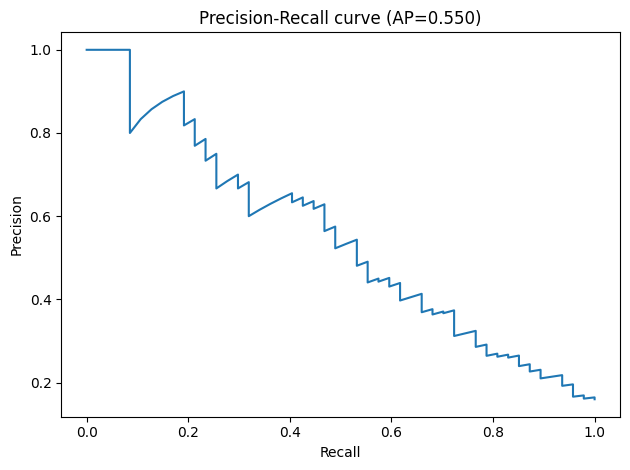

In [5]:
best_name = "LogReg_balanced"  # ou RF si meilleur
p_test = results[best_name]["p_test"]

plot_precision_recall(y_test, p_test)

thr = find_threshold_for_recall(y_test, p_test, target_recall=0.80)
thr

## Évaluation au seuil métier

Une fois le seuil sélectionné :
- le recall sur la classe « départ » augmente,
- la precision peut diminuer,
- l’accuracy globale n’est plus la métrique prioritaire.

Ce compromis est assumé et cohérent avec un objectif de **détection précoce des risques de démission**.


In [6]:
res_thr = evaluate_classifier(models[best_name], X_train, y_train, X_test, y_test, threshold=thr)
print(res_thr["test_report"])
print(res_thr["test_cm"])

              precision    recall  f1-score   support

           0      0.935     0.583     0.718       247
           1      0.264     0.787     0.396        47

    accuracy                          0.616       294
   macro avg      0.600     0.685     0.557       294
weighted avg      0.828     0.616     0.667       294

[[144 103]
 [ 10  37]]


g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


## Conclusion (baselines)

- Le modèle Dummy sert d’étalon : il montre ce qu’on obtient “sans apprendre”.
- La régression logistique (avec class_weight="balanced") fournit une base interprétable et robuste.
- Le modèle non-linéaire (RandomForest) capte d’éventuelles non-linéarités mais peut sur-apprendre.

Le déséquilibre de classes rend la PR-AUC (Average Precision) particulièrement informative.

Étape suivante :
- validation croisée + grid search (fine tuning)
- puis interprétation avec permutation importance + SHAP sur le modèle retenu
